# regression_from_spatial_map

### imports

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import seaborn as sns

In [5]:
import geopandas as gpd

In [6]:
import shapely.wkt

In [7]:
import os

import jax.numpy as jnp
from jax import lax, random
from jax.experimental.ode import odeint
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import print_summary
from numpyro.infer import MCMC, NUTS, Predictive

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_host_device_count(4)


In [8]:
from jax import lax, nn, ops, random, vmap

In [9]:
import numpy as np

In [10]:
import math

In [11]:
pd.set_option('display.max_rows', 40)

In [12]:
pd.options.display.max_columns = None

In [13]:
pd.options.display.max_rows = 40

In [ ]:
pd.options.display.float_format = '{:,.4f}'.format

In [41]:
# NB: replace gpu by cpu to run this notebook in cpu

# Description

This notebook is 2/2 of the trip gen estimation notebooks. Other trip purposes have the characteristic of having a well defined (logically) demographic variable that is also known in the hts sample. In these cases a different and neater method is possible. This notebook contains the estimation steps for where there is not a clear variable map or that variable is not possible to know in the HTS sample, these are:

- HBO (A)
- HBS (A)
- NHBE (P)
- HBEC (A)
- NHBO (A P)
- NHBS (A P)
- NHBW (A P)
- WBW (A P)

What we want is to encode the data present in the HTS data regarding the location of these trips in such a way that it can be predicted entirely from a set of demographic variables. The solution in this notebook is further described throughout however it came about after attempting to do (bayesian) linear regression on this problem and failing miserably. The main issues were:
- In order to have the outcome variable as a count of trips you are forces to choose a level of spatial aggregation to create the input dataset. This is tricky
    - If you go too small (e.g. zone) we are very much at the mercy of our small sample size
    - If you go too big (and in fact any spatial aggregation) you are watering down /ignoring the information in the individual records about how this trip purpose has a tendency to co-locate with a demographic variable
    - This then throws away all my hard work to get demographic data at record level using the buffering trip end method described elsewhere.
- Linear regression doesn't really make sense. An assumption of linear regression is that each component is additive. If you think about the generative model here, it is hard to imagine that the presense of a trip at a location is due to (a little bit of this PLUS a little bit of that). My statistical naivety is showing I know - this is resolved by telling ourselves that we are estimating at population level and we are actually modelling different people (in the same purpose) arriving at that location due to different demographic variables. My solution still has all these flaws but I think it adds some ability for us to reason about all this and improve our input data over time.
- The hts weighting process is really only relevant at the home end -> the assumption that after accounting for the sample vs population rates of from data of the true population / households that the weighting is going to behave at the destination end is a big one. These purposes are typically the ones where this issue is even more pronounced



Firstly, I have adjusted the form of the prediction equation slightly:


## traditional linear regression form

y = b0 x0 + b1 x1 + b2 x2


## proposed form 


y = (R1 x1 d1) + (R2 x2 d2) + (R3 x3 d3) 

where:
- sum(d) = 1
- y = R1 x1 
- y = R2 x2
- y = R3 x3

so that the impact of d is like an apportionment. That way we can seperate out the task of attributing the location of HTS trip ends to the presence of X demographic variable from the task of getting an appropriate trip rate from a relatively low sample.

This can then be converted back to the traditional form by multiplying all r's by d's. But the seperated format should be stored to capture the thought process of a trip gen estimation process.

# Import Data

In [14]:
seqzn = pd.read_parquet('../DataOut/seqzn_demogs_calcs.parquet')

seqzn['geometry'] = seqzn['geometry'].apply(lambda pnt: shapely.wkt.loads(pnt))

# hts data
this hts dataset is a format which brings relevant (according to me) data from pers / hh tables into a single flat file. It also takes the results of getting the presence of each possible demographic variable at either end of the trip. 

In [15]:
hts = pd.read_parquet('../dataout/hts_demog150.parquet') # query demographics from dataset 150m buffere around each hts trip end

In [16]:
hts.DESTPOINT = hts.DESTPOINT.apply(lambda pnt: shapely.wkt.loads(pnt))

hts.ORIGPOINT = hts.ORIGPOINT.apply(lambda pnt: shapely.wkt.loads(pnt))

hts.ORIGPOINT = gpd.GeoSeries(hts.ORIGPOINT,crs={'init':'EPSG:28356'})

hts.DESTPOINT = gpd.GeoSeries(hts.DESTPOINT,crs={'init':'EPSG:28356'})

In [17]:
hts['orig_sa2'] = hts.orig_seqzn.map(seqzn.sa2)

hts['dest_sa2'] = hts.dest_seqzn.map(seqzn.sa2)

hts['orig_sa3'] = hts.orig_seqzn.map(seqzn.sa3)

hts['dest_sa3'] = hts.dest_seqzn.map(seqzn.sa3)

hts['orig_sa4'] = hts.orig_seqzn.map(seqzn.sa4)

hts['dest_sa4'] = hts.dest_seqzn.map(seqzn.sa4)

In [18]:
for sa2_col in ['orig_sa2','orig_sa3','orig_sa4','dest_sa2','dest_sa3','dest_sa4']:
    hts[sa2_col] = hts[sa2_col].fillna(0).astype(int)

In [19]:
hts['ARRTIME0'] = hts.ARRTIME+240

In [20]:
hts.loc[hts.ARRTIME0>1440,'ARRTIME0'] = hts.loc[hts.ARRTIME0>1440,'ARRTIME0'] - 1440

In [21]:
hts['STARTIME0'] = hts.STARTIME+240

In [22]:
hts.loc[hts.STARTIME0>1440,'STARTIME0'] = hts.loc[hts.STARTIME0>1440,'STARTIME0'] - 1440

In [23]:
hts.ARRTIME0 = pd.cut(hts.ARRTIME0,bins=[i * 15 for i in range(99)],labels=([i for i in range(98)])).astype(int)

In [24]:
hts.STARTIME0 = pd.cut(hts.STARTIME0,bins=[i * 15 for i in range(99)],labels=([i for i in range(98)])).astype(int)

In [113]:
new_weight_map = pd.read_csv('../dataout/new_person_weight.csv',index_col=0).Person_Weight

In [115]:
hts['new_trip_weight'] = hts.PERSID.map(new_weight_map)

# functions

In [116]:
def get_productions_raw(demog_vars = [],hts_vars=[]):
    end='orig'
    pa_origins = hts[hts.dir=='PA'][['PERSID','HHID','purp'] + hts_vars + [end + '_' + z for z in ['seqzn', 'sa2', 'sa3', 'sa4']] +['new_trip_weight']+ [end + '_' + v for v in demog_vars]+ ['ORIGPOINT']]
    pa_origins.columns = ['PERSID','HHID','purp'] + hts_vars + ['seqzn', 'sa2', 'sa3', 'sa4'] +['new_trip_weight']+ demog_vars+ ['geometry']
    end='dest'
    ap_destinations = hts[hts.dir=='AP'][['PERSID','HHID','purp'] + hts_vars + [end + '_' + z for z in ['seqzn', 'sa2', 'sa3', 'sa4']] +['new_trip_weight']+ [end + '_' + v for v in demog_vars]+ ['DESTPOINT']]
    ap_destinations.columns = ['PERSID','HHID','purp'] + hts_vars + ['seqzn', 'sa2', 'sa3', 'sa4'] +['new_trip_weight']+ demog_vars+ ['geometry']
    Productions = pd.concat({'pa_origins' : pa_origins, 'ap_destinations' : ap_destinations}).reset_index(level=1,drop=True).reset_index().rename(columns ={'index':'end'})
    Productions[['dir','end']] = Productions['end'].str.split('_',expand=True)
    Productions['end'] = Productions['end'].str.slice(0,-1)
    return Productions

In [117]:
def get_attractions_raw(demog_vars = [],hts_vars=[]):
    end='orig'
    ap_origins = hts[hts.dir=='AP'][['PERSID','HHID','purp'] + hts_vars + [end + '_' + z for z in ['seqzn', 'sa2', 'sa3', 'sa4']] +['new_trip_weight']+ [end + '_' + v for v in demog_vars] + ['ORIGPOINT']]
    ap_origins.columns = ['PERSID','HHID','purp'] + hts_vars + ['seqzn', 'sa2', 'sa3', 'sa4'] +['new_trip_weight']+ demog_vars + ['geometry']
    end='dest'
    pa_destinations = hts[hts.dir=='PA'][['PERSID','HHID','purp'] + hts_vars + [end + '_' + z for z in ['seqzn', 'sa2', 'sa3', 'sa4']] +['new_trip_weight']+ [end + '_' + v for v in demog_vars] + ['DESTPOINT']]
    pa_destinations.columns = ['PERSID','HHID','purp'] + hts_vars + ['seqzn', 'sa2', 'sa3', 'sa4'] +['new_trip_weight']+ demog_vars + ['geometry']
    Attractions = pd.concat({'ap_origins' : ap_origins, 'pa_destinations' : pa_destinations}).reset_index(level=1,drop=True).reset_index().rename(columns ={'index':'end'})
    Attractions[['dir','end']] = Attractions['end'].str.split('_',expand=True)
    Attractions['end'] = Attractions['end'].str.slice(0,-1)
    return Attractions

In [118]:
def get_productions(level = 'sa3', levels=['seqzn', 'sa2', 'sa3', 'sa4'],demog_vars = []):
    zone_agg_list = levels[levels.index(level):]
    demog_agg = ['sum' for i in range(len(demog_vars))]
    end='orig'
    agg_dict = {'new_trip_weight': ['count', 'sum']}
    agg_dict.update(dict(zip([end + '_' + v for v in demog_vars],['mean' for i in range(len(demog_vars))])))
    pa_origins = hts[hts.dir=='PA'].groupby(['purp'] + [end + '_' + z for z in zone_agg_list]).agg(agg_dict).reset_index()
    pa_origins.columns = ['purp'] + zone_agg_list + ['trip_count','trip_weight'] + demog_vars
    end='dest'
    agg_dict = {'new_trip_weight': ['count', 'sum']}
    agg_dict.update(dict(zip([end + '_' + v for v in demog_vars],['mean' for i in range(len(demog_vars))])))
    ap_destinations = hts[hts.dir=='AP'].groupby(['purp'] + [end + '_' + z for z in zone_agg_list]).agg(agg_dict).reset_index()
    ap_destinations.columns = ['purp'] + zone_agg_list + ['trip_count','trip_weight'] + demog_vars
    Productions = pd.concat({'pa_origins' : pa_origins, 'ap_destinations' : ap_destinations}).reset_index(level=1,drop=True).reset_index().rename(columns ={'index':'end'})
    Productions[['dir','end']] = Productions['end'].str.split('_',expand=True)
    Productions['end'] = Productions['end'].str.slice(0,-1)
    return Productions

In [119]:
def get_attractions(level = 'seqzn', levels=['seqzn', 'sa2', 'sa3', 'sa4'],demog_vars = []):
    zone_agg_list = levels[levels.index(level):]
    demog_agg = ['sum' for i in range(len(demog_vars))]
    end='orig'
    agg_dict = {'new_trip_weight': ['count', 'sum']}
    agg_dict.update(dict(zip([end + '_' + v for v in demog_vars],['mean' for i in range(len(demog_vars))])))
    ap_origins = hts[hts.dir=='AP'].groupby(['purp'] + [end + '_' + z for z in zone_agg_list]).agg(agg_dict).reset_index()
    ap_origins.columns = ['purp'] + zone_agg_list + ['trip_count','trip_weight'] + demog_vars
    end='dest'
    agg_dict = {'new_trip_weight': ['count', 'sum']}
    agg_dict.update(dict(zip([end + '_' + v for v in demog_vars],['mean' for i in range(len(demog_vars))])))
    pa_destinations = hts[hts.dir=='PA'].groupby(['purp'] + [end + '_' + z for z in zone_agg_list]).agg(agg_dict).reset_index()
    pa_destinations.columns = ['purp'] + zone_agg_list + ['trip_count','trip_weight'] + demog_vars
    Attractions = pd.concat({'ap_origins' : ap_origins, 'pa_destinations' : pa_destinations}).reset_index(level=1,drop=True).reset_index().rename(columns ={'index':'end'})
    Attractions[['dir','end']] = Attractions['end'].str.split('_',expand=True)
    Attractions['end'] = Attractions['end'].str.slice(0,-1)
    return Attractions

In [120]:
def get_zonal_based_attributes(PorATable, level='sa3', demog_vars = ['Total_Jobs','Retail']):
    out = PorATable.copy(deep=True)
    if level!='seqzn':
        mapper = seqzn.groupby(level)[demog_vars].sum()
        for dv in demog_vars:
            out['zn_'+dv] = out[level].map(mapper[dv])
    else:
        for dv in demog_vars:
            out['zn_'+dv] = out['seqzn'].map(seqzn[dv])
    return out

In [245]:
# a choice
attraction_demog_vals = ['Total_Jobs','Total_Enrolments','Total_Mobile_Pop','Retail',
 'Service', 'Professional', 'Industry', 'Other','Res_0_17', 'Res_18_64', 'Res_65PLUS','Primary','Secondary','Tertiary']

In [122]:
all_atts = get_attractions_raw(demog_vars = attraction_demog_vals)

# Calculate the R's - global rates

In [172]:
sa3_atts = all_atts.groupby(['sa3','purp'])[['new_trip_weight']].sum().reset_index().pivot(index='sa3',columns='purp',values='new_trip_weight')

In [183]:
sa3_atts = sa3_atts.drop(0)

In [173]:
sa3_demogs = seqzn.groupby('sa3')[attraction_demog_vals].sum()

In [190]:
sa3_demogs.index = sa3_demogs.index.astype(int)

In [215]:
data_out_sa3 ={}
data_out_all = {}
for purp in sa3_atts.columns.tolist():
    data_out_sa3[purp] = sa3_demogs.apply(lambda x: sa3_atts[purp]/x)
    data_out_all[purp] = sa3_atts[purp].sum() / sa3_demogs.sum()

In [223]:
global_rates = pd.DataFrame(pd.concat(data_out_all),columns=['global_rate']).reset_index().rename(columns={'level_0':'purp','level_1':'Var'})

In [274]:
global_rates.head()

,purp,Var,global_rate
0,HBEC,Total_Jobs,0.113016
1,HBEC,Total_Enrolments,0.221955
2,HBEC,Total_Mobile_Pop,0.054734
3,HBEC,Retail,0.812168
4,HBEC,Service,0.348499


In [224]:
sa3_rates = pd.concat(data_out_sa3)

In [277]:
sa3_rates.tail() # high variance here suggests that even at sa3 there is substantial variation between the presence of that variable. Which could be due to the weighting applicability at destination end assumption described above

Total_Jobs  Total_Enrolments  Total_Mobile_Pop    Retail   Service  \
    sa3                                                                         
WBW 31606    0.124538          0.278162          0.037171  1.007284  0.389596   
    31607    0.062579          0.130735          0.033601  0.579742  0.132255   
    31608    0.146480          0.253566          0.038349  1.228020  0.420390   
    31701    0.029545          0.052899          0.014597  0.206284  0.080668   
    31903    0.017557          0.033511          0.006601  0.110475  0.055235   

           Professional  Industry     Other  Res_0_17  Res_18_64  Res_65PLUS  \
    sa3                                                                        
WBW 31606      0.583815  0.602523  0.911100  0.165623   0.064023    0.190646   
    31607      0.346031  0.311442  1.686110  0.141090   0.056903    0.196100   
    31608      0.630972  0.632136  2.141360  0.169601   0.065626    0.202338   
    31701      0.123969  0.159200  0.443523  0.058200   0.024618    0.093435   
    31903      0.085509  0.077741  0.190718  0.029068   0.011754    0.031230   

            Primary  Secondary  Tertiary  
    sa3                                   
WBW 31606  0.440043   0.859918  6.264851  
    31607  0.310719   0.371790  0.574366  
    31608  0.529625   0.530935  5.808907  
    31701  0.137258   0.168961  0.175447  
    31903  0.072000   0.087442  0.221443

# Standardisation

Like a lot of these problems the modeller needs to explicitly define their best guess at the lesser of many evils. The effect of standardisation is that it makes the comparison of variables in different units (e.g. enrolments vs jobs vs population) possible along with making some calcs numercially stable. It has the nice effect of turning each individual record of data into a record that is aware of its position in the ditribution of all that series of data. I originally applied standardisation at each sub model (purpose) dataset however, It was then prioritising anomolies in the data too much. Here I have chosen to do it over all attractions ends of all trips in the HTS.  I still beleive that this might be improved further by standardising over larger categories (all enrolments, all population, all jobs) but this needs more thought and testing

In [246]:
all_atts_std = all_atts.copy(deep=True)

In [125]:
all_atts_std[attraction_demog_vals] = all_atts[attraction_demog_vals].apply(lambda c: c.pipe(lambda x: (x - x.mean()) / x.std()).values)

In [30]:
#gpd.GeoDataFrame(all_atts,geometry='geometry',crs={'init':"EPSG:28356"}).to_file('all_attractions.geojson',driver='GeoJSON')

In [32]:
#sns.pairplot(all_atts_std[['Retail','Total_Enrolments','Total_Mobile_Pop']])

In [243]:
#sns.pairplot(A_hbo[A_hbo.Total_Enrolments<2000][['Total_Jobs','Total_Enrolments','Total_Mobile_Pop']])

# Choosing the variables to explore the spatial relationship to

In [241]:
var_dict = {
'HBO' : ['Retail',     'Service',     'Professional',     'Industry',     'Other',   'Res_0_17',     'Res_18_64',     'Res_65PLUS',  'Primary', 'Secondary', 'Tertiary'],
'HBS' : ['Retail',     'Service',     'Professional',     'Industry',     'Other',], 
'NHBE': ['Primary',    'Secondary',   'Tertiary'], 
'HBEC': ['Retail',     'Service',    'Res_0_17',     'Res_18_64',     'Res_65PLUS',  'Primary', 'Secondary', 'Tertiary'], 
'NHBO': ['Retail',     'Service',     'Professional',     'Industry',     'Other',   'Res_0_17',     'Res_18_64',     'Res_65PLUS',  'Primary', 'Secondary', 'Tertiary'], 
'NHBS': ['Retail',     'Service',     'Professional',     'Industry',     'Other'], 
'NHBW': ['Retail',     'Service',     'Professional',     'Industry',     'Other',   'Res_0_17',     'Res_18_64',     'Res_65PLUS',  'Primary', 'Secondary', 'Tertiary'], 
'WBW' : ['Retail',     'Service',     'Professional',     'Industry',     'Other',   'Res_0_17',     'Res_18_64',     'Res_65PLUS',  'Primary', 'Secondary', 'Tertiary']}

# Scale Factor

The softmax function aka the link function in logistic regression and very commonly used in transport choice models. 
\begin{align}
softmax(x)=exp(xi) / \sum_{j} exp(xj)
\end{align}
I had a rude awakening that it is not scale invariant!
Hence,  we need to be concious of the scale of the data before feeding it into the softmax and then the algorythm. Since the data is already standardised (as discussed above) the factor is scaling the mean of each variable uniformly so that the interpreted differces in probability are more or less pronounced. The other factor here is the prior for the dirichlet distribution. Feeding it a number larger than 4 starts to say that we are expecting them to be equal and smaller means we are expecting them to be different. I havent tested that here.

In [261]:
factor = 10

In [262]:
obs_num = 35 #try on different individual records 

<AxesSubplot:>

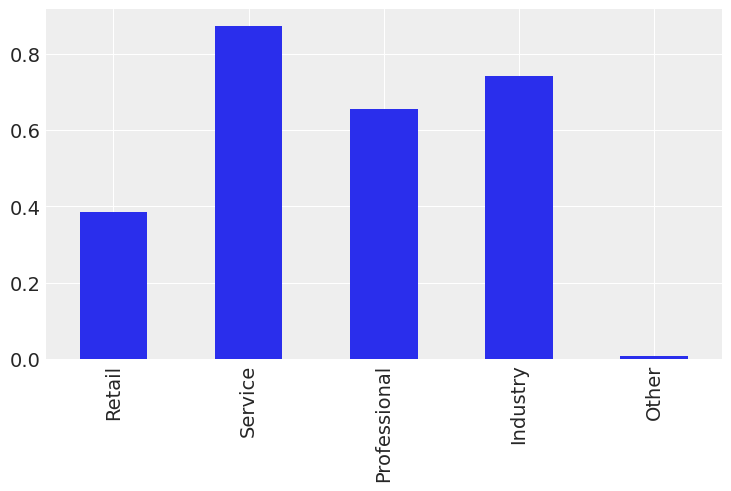

In [263]:
# This is the vanilla standardised variable 
(A_this_purp_std[['Retail',     'Service',     'Professional',     'Industry',     'Other',]]).iloc[obs_num].plot(kind='bar')

<AxesSubplot:>

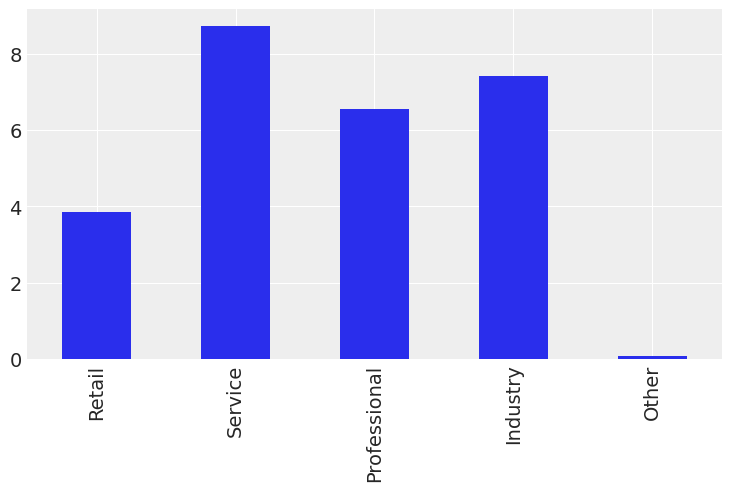

In [264]:
# This is the standardised variable multiplied by the factor. 
(A_this_purp_std[['Retail',     'Service',     'Professional',     'Industry',     'Other',]]*factor).iloc[obs_num].plot(kind='bar')

<AxesSubplot:>

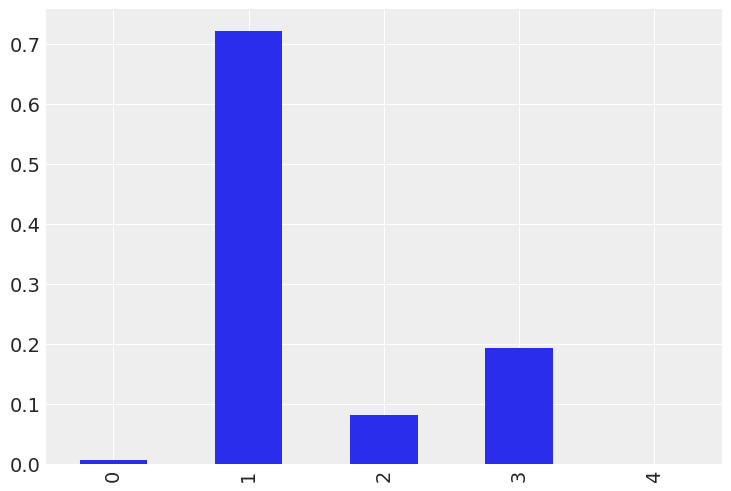

In [266]:
# this is the interpreted probabilities of it being this variable
pd.DataFrame(nn.softmax((A_this_purp_std[['Retail',     'Service',     'Professional',     'Industry',     'Other',]]*factor).values)).iloc[obs_num].plot(kind='bar')

In [267]:
### Want happens if the factor is small

In [270]:
factor = 1

<AxesSubplot:>

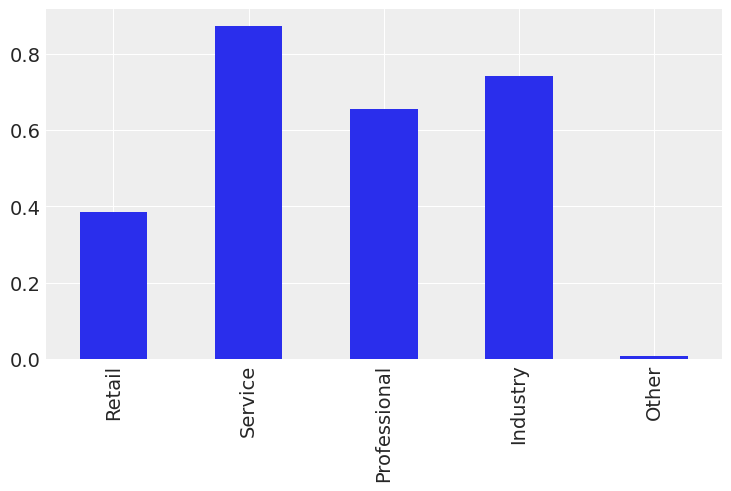

In [271]:
# This is the standardised variable multiplied by the factor. 
(A_this_purp_std[['Retail',     'Service',     'Professional',     'Industry',     'Other',]]*factor).iloc[obs_num].plot(kind='bar')

<AxesSubplot:>

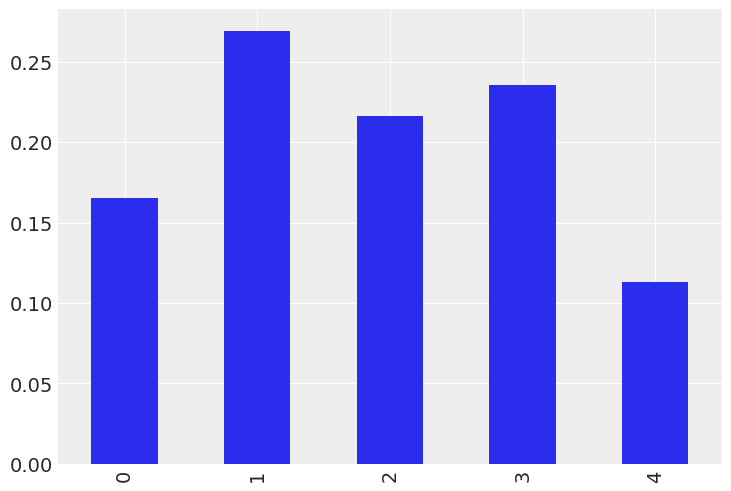

In [272]:
# this is the interpreted probabilities of it being this variable
pd.DataFrame(nn.softmax((A_this_purp_std[['Retail',     'Service',     'Professional',     'Industry',     'Other',]]*factor).values)).iloc[obs_num].plot(kind='bar')

In [273]:
# note the impact of this factor is how much you want the model to be sensitive to differences in the observed hts variable at trip end location

# The Model
this model has been modified from Richard McElreath's book Statistical Rethinking. He has an example in chapter 16 where there was an experiment on children selecting boxes after observing other children making a choice. The model was trying to infer the probabilities of different strategies (latent!!) existing given just the experimental data. I have always dreamed of being at the level of applying a similar process as David Blei in topic modelling / Latent Dirichlet Allocation and I think this is the closest I may ever come. I have modified the example model (no way I could code this from scratch!) so that the demographic variables themselves are the strategies (further explained below) and put it in a big loop to do it over purpose. Richard taught me to describe the model like this:



\begin{align}
\large
y_i \sim Categorical(  d_j ) \\
\large
d_j = \sum_{x=1}^{n} p_s Pr(j|s) \\
\large
p_s = Dirichlet([4,4,4,.n])
\end{align}

How to think about this model:
    say we had a HBEP attraction location that was at a location which yielded for the "X" array of [enrolments, population, jobs] the values - [10,0,0]
    for this one we know that the demographic variable that is the thing we want to map and hence

\begin{align}
\large
Pr ( yi = [10,0,0], s=enrolment) = 1
\end{align}

Just like in the example, we don't know s (interpreted here as the one variable that is the ~cause of this trip being located here). But from a manually calibrated softmax function we can get the probabilities of s.

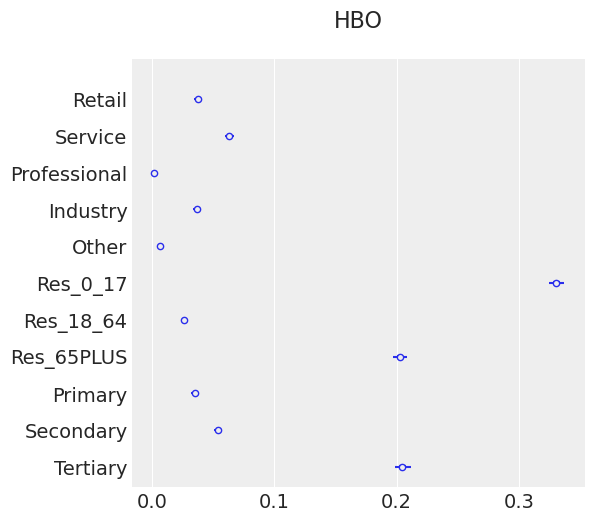

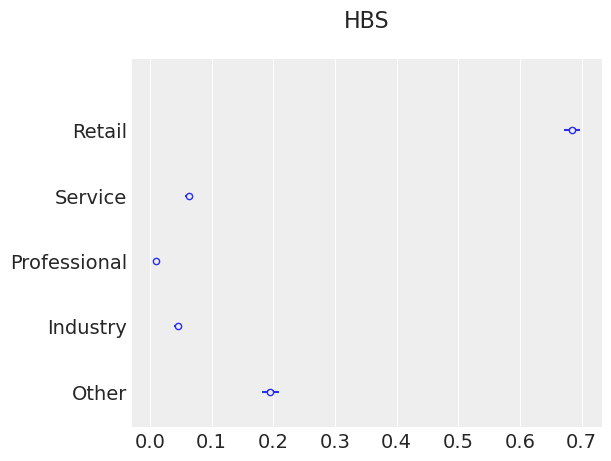

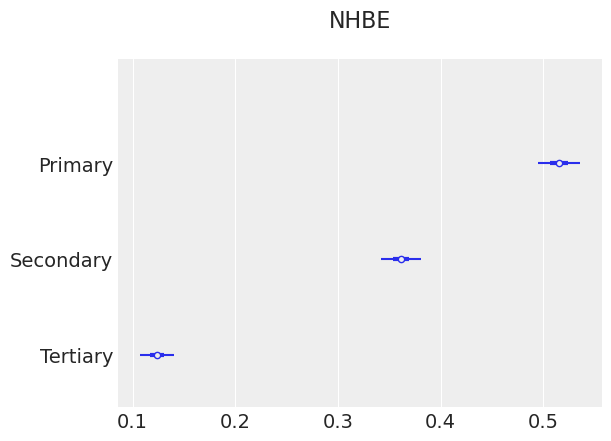

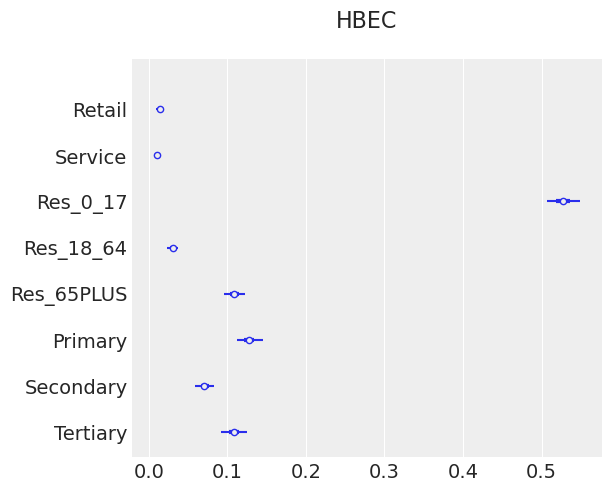

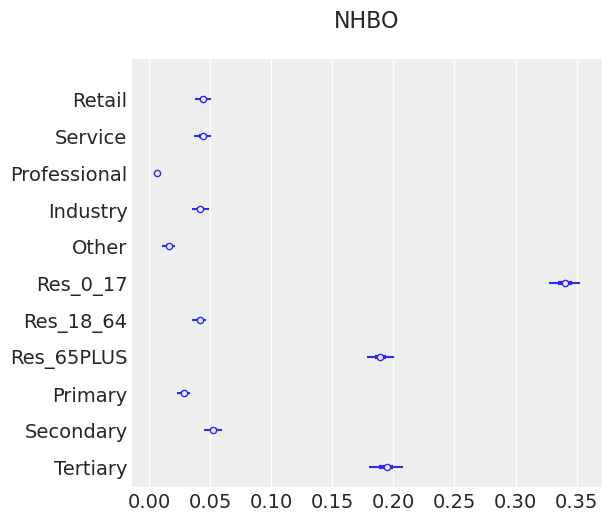

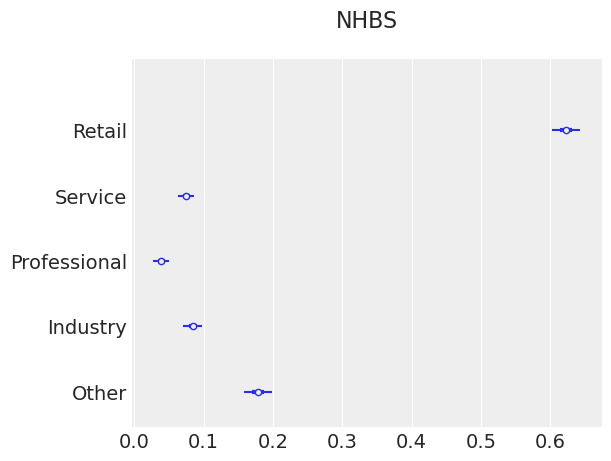

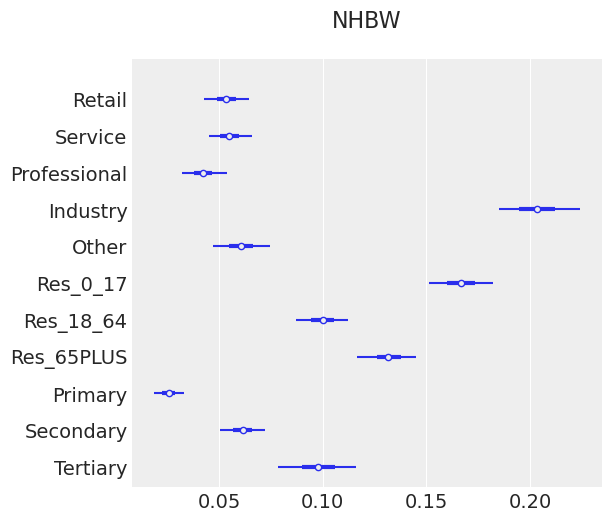

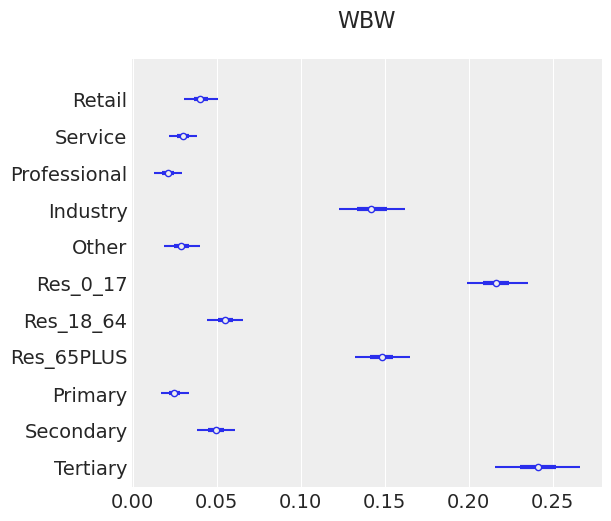

In [242]:

coeffs_out = {}

for purp in ['HBO', 'HBS', 'NHBE', 'HBEC', 'NHBO', 'NHBS', 'NHBW', 'WBW']:
    #print(purp)
    A_this_purp_std = all_atts_std[var_dict[purp]][all_atts_std.purp==purp]
    
    #A_this_purp_std = A_this_purp[var_dict[purp]].apply(lambda c: c.pipe(lambda x: (x - x.mean()) / x.std()).values)
    
    len_vars = len(var_dict[purp])
    
    softmax_std = nn.softmax(A_this_purp_std.values * 7.5)
    
    dat_list = dict(
        softmax_std=softmax_std
    )
    
    # in this model we had records of individual trials and then built a dirichlet distribution 
    def Boxes_model(softmax_std):
        # prior
        p = numpyro.sample("p", dist.Dirichlet(jnp.repeat(4, len_vars)))    
        
        phi = [None] * len_vars
        
        # compute log( p_s * Pr(y_i|s )
        for j in range(len_vars):
            phi[j] = jnp.log(p[j]) + jnp.log(softmax_std[:,j:j+1])
        # compute average log-probability of y
        numpyro.factor("logprob", logsumexp(jnp.stack(phi, axis=1), axis=1))
        
    m16_2 = MCMC(NUTS(Boxes_model), 1000, 1000, num_chains=3)
    
    m16_2.run(random.PRNGKey(0), **dat_list)
    
    inf_data = az.from_numpyro(m16_2)
    
    coeffs = az.summary(inf_data)
    
    #coeffs = coeffs.rename(columns={'mean':purp})
    p_labels = var_dict[purp]
    means_out = coeffs['mean']
    means_out.index=p_labels
    coeffs_out[purp] = means_out
    
    # show marginal posterior for p
    
    #print(purp)
    
    az.plot_forest(
        m16_2.get_samples(group_by_chain=True), combined=True, var_names="p", hdi_prob=0.89,
    )
    plt.gca().set_yticklabels(p_labels[::-1]) # matplotlib needs labels in reverse order?
    plt.gca().set_title(purp + "\n")
    plt.savefig(purp + '.png')